## Modeling for predicting critical outcome at ED disposition

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,False,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,False,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,False,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,False,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,False,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


### 1. task-specific filter

In [4]:
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['ed_death'] == False)]
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))

After filtering: training size = 353150 , testing size = 88287
After filtering: training size = 353142 , testing size = 88284


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
print('positiave : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positiave : negative = 0.06329639889196675 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/miniconda3/envs/mimic-ed/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.890993595123291 seconds
AUC: 0.850166009329999
AUPRC: 0.34135211370905194
Sensitivity: 0.773109243697479
Specificity: 0.7728666418170669
Score thresold: 0.059059310080870495
2.5 97.5


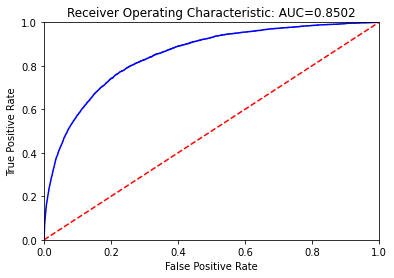

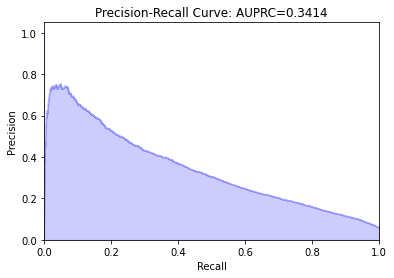

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task4_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 45.07501029968262 seconds
AUC: 0.9317644984407443
AUPRC: 0.5607970142167293
Sensitivity: 0.8719953097518077
Specificity: 0.8328904493368764
Score thresold: 0.09
2.5 97.5


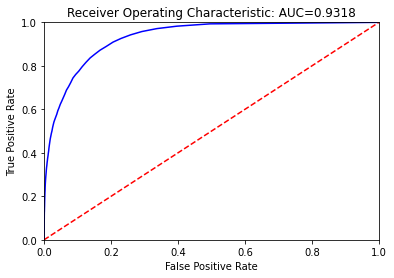

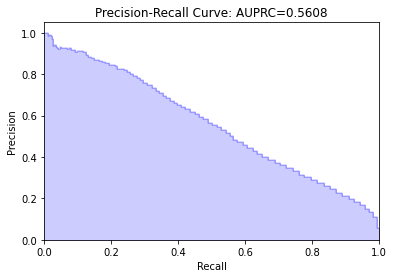

[0.06259944 0.01054691 0.00473972 0.00769783 0.01354848 0.00477348
 0.00759129 0.01268806 0.00279243 0.00515305 0.01004513 0.03139091
 0.08145207 0.00480424 0.00438181 0.00324068 0.00093607 0.0014047
 0.00177263 0.0018367  0.0036362  0.00231871 0.00214762 0.00352673
 0.00445594 0.00349002 0.00369362 0.0021236  0.00499413 0.00187087
 0.00198166 0.00343002 0.00509394 0.00345792 0.00191318 0.00384979
 0.00404797 0.00220296 0.00278851 0.00083813 0.00526981 0.00340839
 0.00330395 0.00395207 0.0065566  0.00397263 0.00382014 0.00135361
 0.00397375 0.00387243 0.00338512 0.00509306 0.00168423 0.00313815
 0.00323813 0.00257584 0.00171427 0.00464036 0.05541702 0.0843248
 0.0781936  0.0346292  0.06912468 0.05821061 0.11985312 0.05367701
 0.04636025]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 67.65194177627563 seconds
AUC: 0.9332459059848828
AUPRC: 0.5535999531038744
Sensitivity: 0.8604651162790697
Specificity: 0.8450587372395301
Score thresold: 0.07397350161329301
2.5 97.5


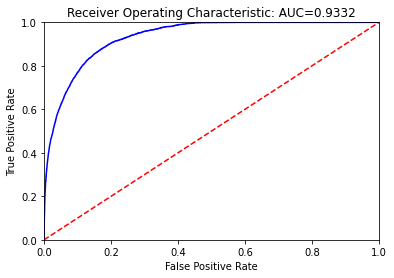

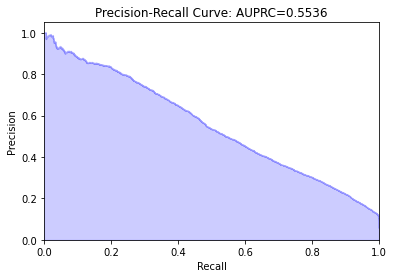

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [16]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_disposition_mlp')

2022-08-29 19:21:30.757893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 19:21:31.604909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-08-29 19:21:31.605894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22304 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/20
  37/1766 [..............................] - ETA: 7s - loss: 0.4466 - accuracy: 0.9172 - auc: 0.7220 - auprc: 0.1352 - true_positives: 37.0000 - true_negatives: 6750.0000 - precision: 0.1486 - recall: 0.0845          

2022-08-29 19:21:33.459069: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1766/1766 [==============================] - 11s 5ms/step - loss: 0.1715 - accuracy: 0.9413 - auc: 0.8788 - auprc: 0.3767 - true_positives: 4934.0000 - true_negatives: 327469.0000 - precision: 0.5148 - recall: 0.2347
Epoch 2/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1458 - accuracy: 0.9468 - auc: 0.9092 - auprc: 0.4655 - true_positives: 5934.0000 - true_negatives: 328418.0000 - precision: 0.6158 - recall: 0.2823
Epoch 3/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1401 - accuracy: 0.9481 - auc: 0.9170 - auprc: 0.4892 - true_positives: 6134.0000 - true_negatives: 328674.0000 - precision: 0.6403 - recall: 0.2918
Epoch 4/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1361 - accuracy: 0.9489 - auc: 0.9226 - auprc: 0.5099 - true_positives: 6213.0000 - true_negatives: 328901.0000 - precision: 0.6587 - recall: 0.2955
Epoch 5/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1336 - accuracy: 0.9498 

MLP:
2759/2759 [==============================] - 3s 1ms/step
AUC: 0.9370231396955289
AUPRC: 0.5584747437727661
Sensitivity: 0.8716044557357827
Specificity: 0.8424014332607885
Score thresold: 0.07753433
2.5 97.5


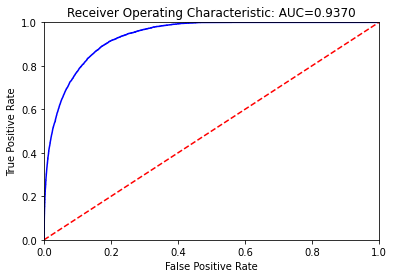

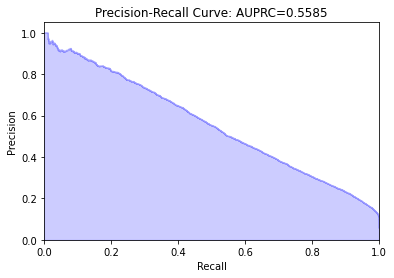

In [17]:
print("MLP:")
mlp = load_model('critical_disposition_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [18]:
# Loading data for LSTM
resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [19]:
train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [20]:
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

In [21]:
# skip this cell if not retraining
lstm = LSTM_MLP()
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

start = time.time()
lstm.fit(train_data_gen, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('critial_disposition_lstm')

Epoch 1/20


2022-08-29 19:24:46.220516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


1766/1766 [==============================] - 1070s 605ms/step - loss: 0.1820 - accuracy: 0.9404 - auc: 0.8701 - auprc: 0.3409 - true_positives: 4366.0000 - true_negatives: 327734.0000 - precision: 0.4989 - recall: 0.2077
Epoch 2/20
1766/1766 [==============================] - 1084s 614ms/step - loss: 0.1422 - accuracy: 0.9479 - auc: 0.9138 - auprc: 0.4931 - true_positives: 6385.0000 - true_negatives: 328344.0000 - precision: 0.6284 - recall: 0.3037
Epoch 3/20
1766/1766 [==============================] - 1088s 616ms/step - loss: 0.1367 - accuracy: 0.9500 - auc: 0.9207 - auprc: 0.5206 - true_positives: 6970.0000 - true_negatives: 328529.0000 - precision: 0.6600 - recall: 0.3316
Epoch 4/20
1766/1766 [==============================] - 1091s 618ms/step - loss: 0.1316 - accuracy: 0.9513 - auc: 0.9270 - auprc: 0.5442 - true_positives: 7287.0000 - true_negatives: 328647.0000 - precision: 0.6772 - recall: 0.3466
Epoch 5/20
1766/1766 [==============================] - 1094s 619ms/step - loss: 0.

INFO:tensorflow:Assets written to: critial_disposition_lstm/assets


INFO:tensorflow:Assets written to: critial_disposition_lstm/assets


LSTM:
442/442 [==============================] - 273s 618ms/step
AUC: 0.9476721198987871
AUPRC: 0.6079258617485223
Sensitivity: 0.8762947039280828
Specificity: 0.8683732730530138
Score thresold: 0.07288276
2.5 97.5


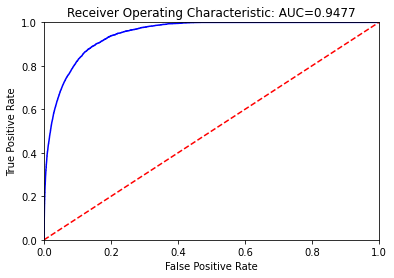

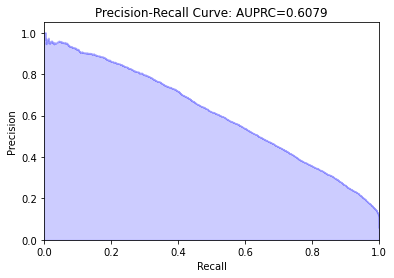

In [22]:
print("LSTM:")
lstm = load_model('critial_disposition_lstm')
probs = lstm.predict(test_data_gen)
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [23]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8038070676582674
AUPRC: 0.1937968667672909
Sensitivity: 0.8698456126636701
Specificity: 0.6400735868794113
Score thresold: -2.0
2.5 97.5


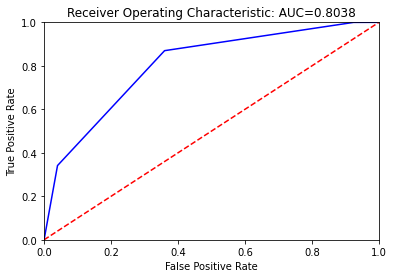

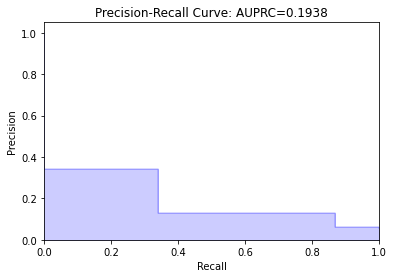

In [24]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

score_NEWS
AUC: 0.6341552070549584
AUPRC: 0.14107424569952362
Sensitivity: 0.4637482900136799
Specificity: 0.7954477136364183
Score thresold: 2
2.5 97.5


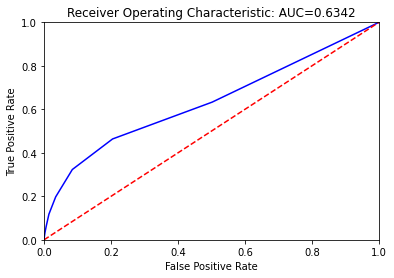

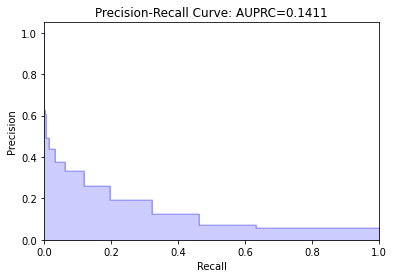

In [25]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6164684225054229
AUPRC: 0.12759581535748216
Sensitivity: 0.4103967168262654
Specificity: 0.8225257614197939
Score thresold: 2
2.5 97.5


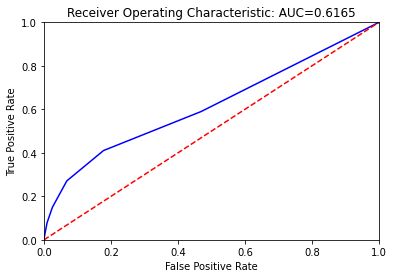

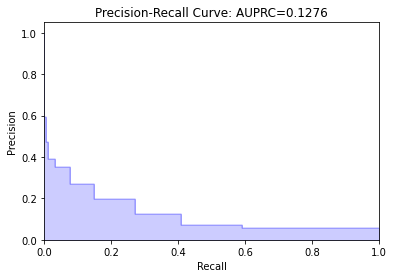

In [26]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6857535825991775
AUPRC: 0.10537924182262862
Sensitivity: 0.680672268907563
Specificity: 0.6155326030757391
Score thresold: 5
2.5 97.5


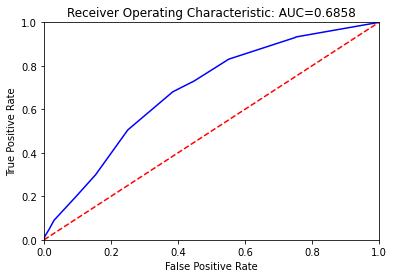

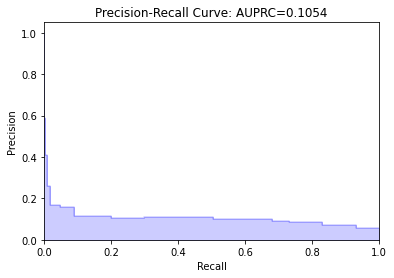

In [27]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6134507698002305
AUPRC: 0.10312450014069556
Sensitivity: 0.43033027164354115
Specificity: 0.7698486178412111
Score thresold: 2
2.5 97.5


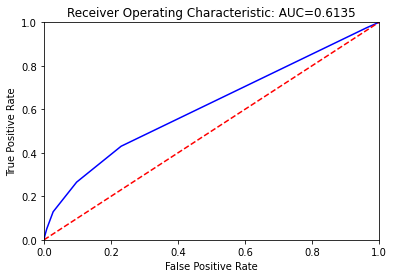

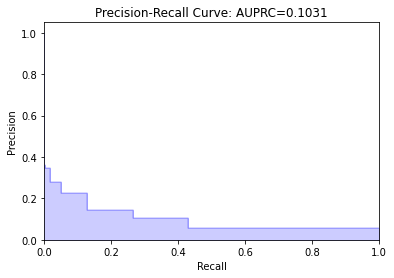

In [28]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7072443593699913
AUPRC: 0.14141537005977523
Sensitivity: 0.5896032831737346
Specificity: 0.7306744261546045
Score thresold: 6
2.5 97.5


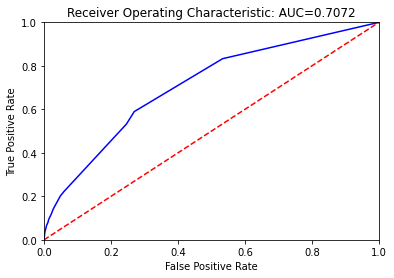

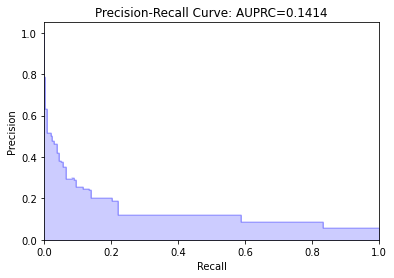

In [29]:
get_score_performance("score_CART", random_seed=random_seed)

### 4. Performance output

In [30]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                              'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                              'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                              'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_disposition.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task4.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.059,0.85 (0.847-0.854),0.341 (0.327-0.356),0.773 (0.76-0.786),0.773 (0.763-0.784),2.891
1,RF,0.090,0.932 (0.93-0.934),0.561 (0.554-0.572),0.872 (0.847-0.877),0.833 (0.832-0.858),45.075
2,GB,0.074,0.933 (0.932-0.936),0.554 (0.546-0.565),0.86 (0.849-0.872),0.845 (0.837-0.853),67.652
3,MLP,0.078,0.937 (0.936-0.939),0.558 (0.551-0.571),0.872 (0.864-0.894),0.842 (0.831-0.85),183.944
4,LSTM,0.073,0.948 (0.946-0.949),0.608 (0.603-0.62),0.876 (0.87-0.89),0.868 (0.86-0.872),21829.188
5,ESI,-2.000,0.804 (0.799-0.808),0.194 (0.187-0.201),0.87 (0.861-0.875),0.64 (0.637-0.643),0.000
6,score_NEWS,2.000,0.634 (0.627-0.64),0.141 (0.132-0.147),0.464 (0.452-0.476),0.795 (0.793-0.798),0.000
7,score_NEWS2,2.000,0.616 (0.61-0.623),0.128 (0.121-0.135),0.41 (0.399-0.592),0.823 (0.532-0.825),0.000
8,score_REMS,5.000,0.686 (0.682-0.691),0.105 (0.101-0.11),0.681 (0.671-0.689),0.616 (0.613-0.618),0.000
9,score_MEWS,2.000,0.613 (0.608-0.619),0.103 (0.099-0.109),0.43 (0.419-0.438),0.77 (0.768-0.772),0.000


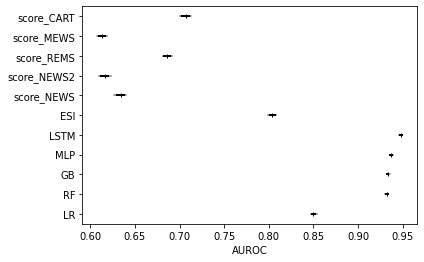

In [31]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

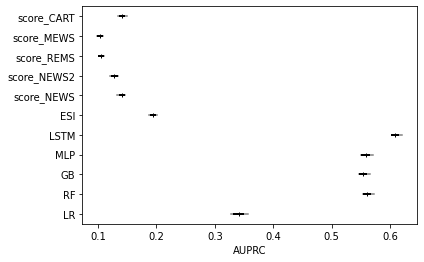

In [32]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [33]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
64,ed_los,0.119853
59,ed_heartrate_last,0.084325
12,triage_acuity,0.081452
60,ed_resprate_last,0.078194
62,ed_sbp_last,0.069125
0,age,0.062599
63,ed_dbp_last,0.058211
58,ed_temperature_last,0.055417
65,n_med,0.053677
66,n_medrecon,0.046360
